This code has been modified by Dr. Md Tanvir Arafin - mdtanvir.arafin@morgan.edu, & Jose Dominguez - jodom4@morgan.edu

In [1]:
from datetime import datetime
import pytz

StartTime= datetime.now(pytz.timezone('America/New_York') )
current_time = StartTime.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 23:40:09


In [2]:
!pip install nengo
!pip install numpy
!pip install sklearn
!pip install  matplotlib

In [3]:
import nengo
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#fetch data
mnist = sklearn.datasets.fetch_openml('mnist_784')

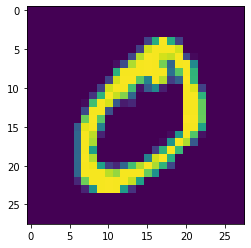

In [5]:
#DEBUG (view data)
sample = 1
image = mnist['data'][sample]
image = image.reshape(28,28)
# plot the sample
fig = plt.figure
plt.imshow(image)
plt.show()

In [6]:
## data preprocessing
x = mnist['data'].astype(float)-128
x = x/np.linalg.norm(x, axis=1)[:,None]
       
y = mnist['target']
y = np.eye(10)[y.astype(int)]*2-1
y = y/np.linalg.norm(y, axis=1)[:,None]

order = np.arange(len(x))
np.random.shuffle(order)
x = x[order]
y = y[order]


In [7]:
#parameters
n_training=500   #number of training images
n_testing=100    #number of testing images


n_neurons=500    #number of neurons
synapse=0.02
t_image=0.5      #time per image
dt = 0.001

In [8]:
#simple python version of a LIF neuron

class SimpleNeuron:
    def __init__(self):
        self.v = 0
    def step(self, J):
        self.v += J
        if self.v < 0:
            self.v = 0
        if self.v > 5:
            spike = 1
            self.v = 0
        else:
            spike = 0
        return spike

In [9]:

def stim_func(t, data=x[:n_training]):
    index = int(t / t_image)
    return data[index % len(data)]

In [10]:
time = dt*np.linspace(0, int(t_image*n_training/dt), int(t_image*n_training/dt))
time2 = np.linspace(0, int(t_image*n_training), int(t_image*n_training))
stim  = [stim_func(t) for t in time]

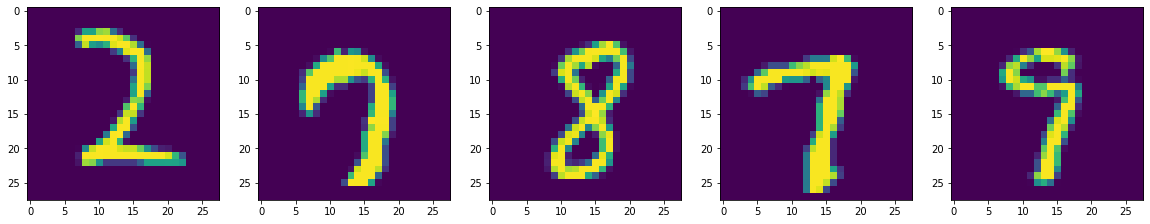

In [11]:
#DEBUG (view data)
plt.figure(figsize=(20,10))
columns = 5
plt.subplot(151)
plt.imshow(stim[1].reshape(28,28))
plt.subplot(152)
plt.imshow(stim[501].reshape(28,28))
plt.subplot(153)
plt.imshow(stim[1001].reshape(28,28))
plt.subplot(154)
plt.imshow(stim[1501].reshape(28,28))
plt.subplot(155)
plt.imshow(stim[2001].reshape(28,28))

In [12]:
def target_func(t, data=y[:n_training]):
    index = int(t / t_image)
    c = np.argmax(data[index% len(data)])
    return c

In [13]:
target  = [target_func(t) for t in time]

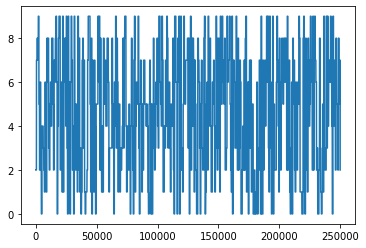

In [14]:
#DEBUG
plt.plot(target)

In [15]:
N = n_neurons  # Number of neurons
dimensions = 784
neurons = [SimpleNeuron() for i in range(N)]
E = np.random.normal(size=(N, dimensions))
B = np.random.normal(size=(N))*0.1

A = np.zeros((len(stim), N))
for i, J in enumerate(stim):
    if (i%1000 ==0):
      print(i)
    Js = np.dot(E, J)
    for k, JJ in enumerate(Js):
        A[i,k] = neurons[k].step(JJ+B[k])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [16]:
filt = nengo.synapses.Lowpass(0.075)
D, info = nengo.solvers.LstsqL2(reg=0.1)(filt.filt(A), target)

In [17]:
#Quick Overwrite for number of testing images
n_testing=100

In [18]:
def test_x_func(t, data=x[n_training:]):
    index = int(t / t_image)
    return data[index % len(data)]

In [19]:
time = dt*np.linspace(0, int(t_image*n_testing/dt), int(t_image*n_testing/dt))

In [20]:
test_input  = [test_x_func(t) for t in time]

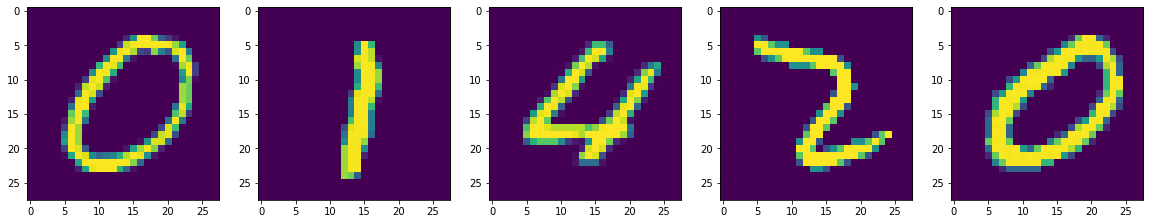

In [21]:
#DEBUG (view data)
plt.figure(figsize=(20,10))
columns = 5
plt.subplot(151)
plt.imshow(test_input[1].reshape(28,28))
plt.subplot(152)
plt.imshow(test_input[501].reshape(28,28))
plt.subplot(153)
plt.imshow(test_input[1001].reshape(28,28))
plt.subplot(154)
plt.imshow(test_input[1501].reshape(28,28))
plt.subplot(155)
plt.imshow(test_input[2001].reshape(28,28))

In [22]:
# calclulate A matrix for test
A_test = np.zeros((len(test_input), N))
for i, J in enumerate(test_input):
    if (i%1000 ==0):
      print(i)
    Js = np.dot(E, J)
    for k, JJ in enumerate(Js):
        A_test[i,k] = neurons[k].step(JJ+B[k])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


In [23]:
def test_y_func(t, data=y[n_training:]):
    index = int(t / t_image)
    c = np.argmax(data[index% len(data)])
    return c

In [24]:
target  = [test_y_func(t) for t in time]

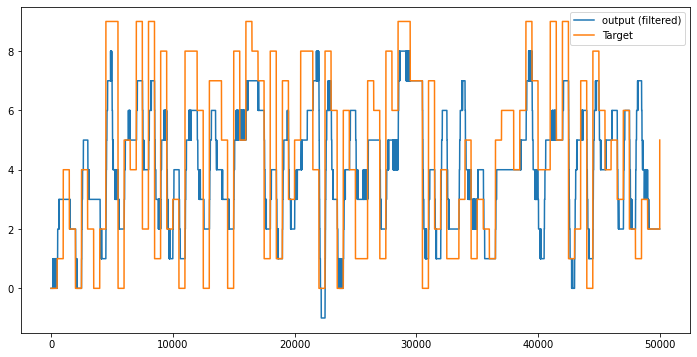

In [25]:
plt.figure(figsize=(12,6))
plt.plot(np.floor(filt.filt(A_test.dot(D))), label='output (filtered)')
plt.plot(target, label='Target')
plt.legend()

In [29]:
## Accuracy
output = filt.filt(A_test.dot(D))
confusion = np.zeros((10,10), dtype=int)
count = np.zeros(10, dtype=int)
for i in range(n_testing):
  t = (i + 1) * t_image
  index = np.argmax(time >= t) - 1
  count[target[index]] += 1
  confusion[target[index],int(output[index])] += 1
score = sum(confusion[i, i] for i in range(10)) / float(n_testing)
print("Accuracy: ",score)

Accuracy:  0.18


In [27]:
#Record total time to run the whole simulation
EndTime = datetime.now(pytz.timezone('America/New_York'))
TotalSimTime = EndTime - StartTime
print("Overall Sim TIme=", TotalSimTime)
#Time Format H:M:S

Overall Sim TIme= 0:11:28.590393
